# 3D (x-y-t) field generation and lagrangian simulation

This example will cover:

 - Generation of a synthetic x-y-t field
 - Advection of sample drifters

Prerequisite, have parcels installed, see [OceanParcels doc](https://oceanparcels.org).
If under conda environment: `conda install -c conda-forge parcels`

In [1]:
from gptide import cov
from gptide import GPtideScipy

import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from gptide import stats as gpstats

In [2]:
from dask.distributed import Client
client = Client()

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60210,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:60222,Total threads: 1
Dashboard: http://127.0.0.1:60226/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:60213,


## Generate some data

In [5]:
####
# These are our kernel input parameters
np.random.seed(1)
noise = 0.01
#η = 10 
η = .2 # 
ℓ_x = 100e3 # meters
ℓ_y = 100e3 # meters
ℓ_t = 86400*5 # seconds

###
# Domain size parameters
Nx = 1000
Ny = 1000
#Nt = 24*60
Nt = 60*2
#
#Nx = 10
#Ny = 20
#Nt = 24
# output grid spacing
dx = 1000.
dy = 1000.
#dt = 3600.
dt = 86400//2

t_x = np.arange(Nx)[:, None]*dx
t_y = np.arange(Ny)[:, None]*dy
t_t = np.arange(Nt)[:, None]*dt

Cov_x = cov.matern32(t_x, t_x.T, ℓ_x)
Cov_y = cov.matern32(t_y, t_y.T, ℓ_y)
Cov_t = cov.matern32(t_t, t_t.T, ℓ_t)

#Cov_x = cov.matern32(t_x, t_x.T, ℓ_x) + noise * np.eye(Nx)
#Cov_y = cov.matern32(t_y, t_y.T, ℓ_y) + noise * np.eye(Ny)
#Cov_t = cov.matern32(t_t, t_t.T, ℓ_t) + noise * np.eye(Nt)
#Cov_t = cov.matern32(t_t, t_t.T, ℓ_t) * cov.cosine(t_t, t_t.T, 86400/2) + noise * np.eye(Nt)

# Input data points
xd = np.arange(0,dx*Nx,dx)[:,None]-dx/2
yd = np.arange(0,dy*Ny,dy)[:,None]-dy/2
td = np.arange(0,dt*Nt,dt)[:,None]-dt/2

Text(0.5, 1.0, 't Covariance')

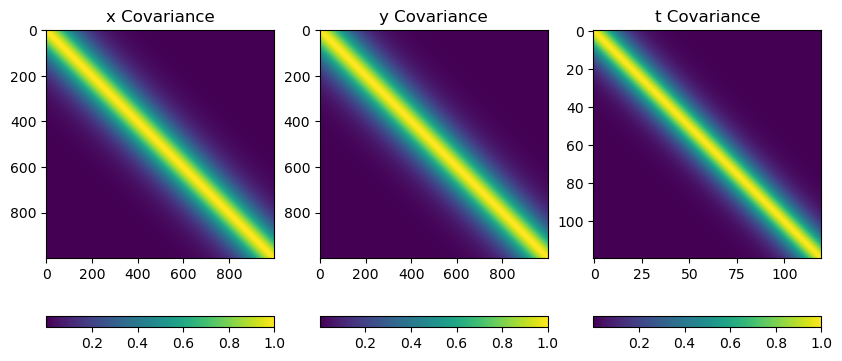

In [6]:
fig, axes = plt.subplots(1,3, figsize=(10,5))

ax = axes[0]
h = ax.imshow(Cov_x)
plt.colorbar(h, location="bottom")
ax.set_title("x Covariance")

ax = axes[1]
h = ax.imshow(Cov_y)
plt.colorbar(h, location="bottom")
ax.set_title("y Covariance")

ax = axes[2]
h = ax.imshow(Cov_t)
plt.colorbar(h, location="bottom")
ax.set_title("t Covariance")

## Cholesky decomposition and sample generation

In [7]:
Lx = np.linalg.cholesky(Cov_x)
Ly = np.linalg.cholesky(Cov_y)
Lt = np.linalg.cholesky(Cov_t)

# start converting to dask arrays
t_chunk = 5
#Lt_dask = da.from_array(Lt).persist()
Lt_dask = da.from_array(Lt, chunks=(t_chunk, -1)).persist()

# generate sample
U = da.random.normal(0, 1, size=(Nx,Ny,Nt), chunks=(-1, -1, t_chunk))
V = da.random.normal(0, 1, size=(Nx,Ny,Nt), chunks=(-1, -1, t_chunk))

# noise
u_noise = noise * da.random.normal(0, 1, size=(Nx,Ny,Nt), chunks=(-1, -1, t_chunk))
v_noise = noise * da.random.normal(0, 1, size=(Nx,Ny,Nt), chunks=(-1, -1, t_chunk))

In [8]:
# 2D
#zg = η * Lx @ V @ Lt.T

# 3D

# with dask
#zg = η * da.einsum("ij,kl,mn,jln->ikm", Lx, Ly, Lt_dask, V)

# with opt_einsum
import opt_einsum as oe
u = η * oe.contract("ij,kl,mn,jln", Lx, Ly, Lt_dask, U)
v = η * oe.contract("ij,kl,mn,jln", Lx, Ly, Lt_dask, V)

u

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 24
  intermediate = blockwise(
/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 24
  intermediate = blockwise(


dask.array<mul, shape=(1000, 1000, 120), dtype=float64, chunksize=(1000, 1000, 5), chunktype=numpy.ndarray>

In [9]:
# store
ds = xr.Dataset(dict(U=(("x", "y", "time"), u + u_noise), 
                     V=(("x", "y", "time"), v + v_noise),
                    ),
                coords=dict(x=("x", xd[:,0]), y=("y", yd[:,0]), time=("time", td[:,0])),
               )
ds["time"].attrs["units"] = "seconds"
ds = ds.transpose("time", "y", "x")

ds.to_zarr("uv_3D.zarr", mode="w")

### reload and plot

In [10]:
ds = xr.open_zarr("uv_3D.zarr", decode_times=False)

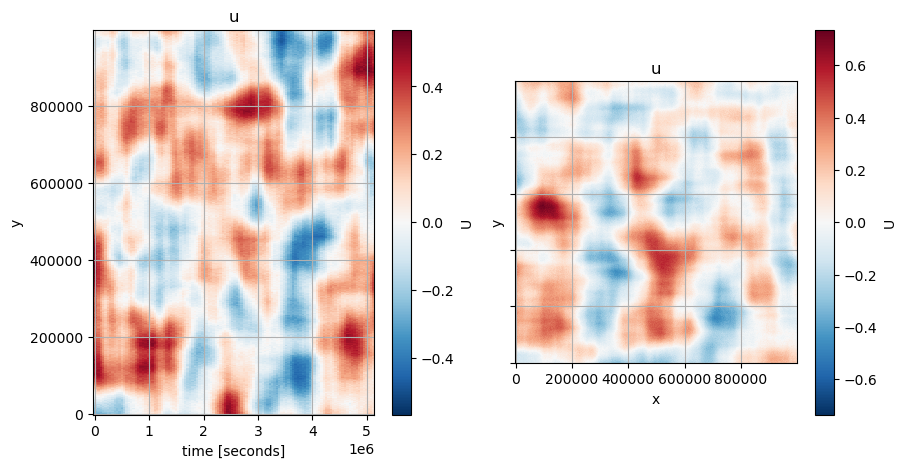

In [11]:
fig, axes = plt.subplots(1,2,figsize=(10,5), sharey=True)

ax = axes[0]
ds.U.isel(x=ds.x.size//2).plot(ax=ax, x="time", y="y")
ax.grid()
ax.set_title("u")

ax = axes[1]
ds.U.isel(time=0).plot(ax=ax, x="x", y="y")
ax.grid()
ax.set_title("u")
ax.set_aspect("equal")

## setup parcels

In [12]:
from datetime import timedelta

import xarray as xr

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    plotTrajectoriesFile,
)

In [13]:
ds = xr.open_zarr("uv_3D.zarr", decode_times=False)
ds = ds.rename(x="lon", y="lat")

In [14]:
nb = 2
bounds = (float(ds["lon"].values[0])  + nb*dx,
          float(ds["lon"].values[-1]) - nb*dx,
          float(ds["lat"].values[0])  + nb*dy,
          float(ds["lat"].values[-1]) - nb*dy,
)

#buffer = (dx*2, float(xd[-1])-2*dx)
#buffer = 2*dx, 2*dy
#mask = (  (ds.lon>ds.lon[0]+buffer[0]) & (ds.lon<ds.lon[-1]-buffer[0]) 
#        & (ds.lat>ds.lat[0]+buffer[1]) & (ds.lat<ds.lat[-1]-buffer[1])
#       )
#ds["U"] = ds["U"].where( mask )
#ds["V"] = ds["V"].where( mask )

#ds_in = ds

In [15]:
fieldset = FieldSet.from_xarray_dataset(
    ds,
    variables=dict(U="U", V="V"),
    dimensions=dict(lon="lon", lat="lat", time="time"),                         
    mesh="flat",
)

In [16]:
_ds = ds.isel(lon=slice(10,-10,10), lat=slice(10,-10,10))
x0 = (_ds.lon   + _ds.lat*0).values.flatten()
y0 = (_ds.lon*0 + _ds.lat  ).values.flatten()

In [17]:
pset = ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=x0,  # a vector of release longitudes
    lat=y0,  # a vector of release latitudes
    #time=t0,
)

In [18]:
#print(pset)

In [19]:
#pset.show(field=fieldset.U)

In [20]:
zarr = "parcels_3D.zarr"

output_file = pset.ParticleFile(
    name=zarr,  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)

Tmax = np.floor(td.max()/86400)

#b0, b1, b2, b3 = bounds
fieldset.add_constant('b0', bounds[0])
fieldset.add_constant('b1', bounds[1])
fieldset.add_constant('b2', bounds[2])
fieldset.add_constant('b3', bounds[3])

def StopParticle(particle, fieldset, time):
    # https://github.com/OceanParcels/parcels/blob/bf98c977a260afd86e91ce7af8f3af7dfef90edf/docs/examples/example_stommel.py#L86
    # https://docs.oceanparcels.org/en/latest/reference/particles.html#module-parcels.particle
    #if (particle.lon < bounds[0]) or (particle.lon > bounds[1]) or (particle.lat < bounds[2]) or (particle.lat > bounds[2]):
    if (particle.lon < fieldset.b0) or (particle.lon > fieldset.b1) \
        or (particle.lat < fieldset.b2) or (particle.lat > fieldset.b3):
        particle.delete()


pset.execute(
    AdvectionRK4+pset.Kernel(StopParticle),  # the kernel (which defines how particles move)
    #AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=Tmax),  # the total length of the run
    dt=timedelta(minutes=30),  # the timestep of the kernel
    #dt=timedelta(minutes=30),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Compiled ArrayJITParticleAdvectionRK4StopParticle ==> /var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/parcels-501/lib2f6913ffeca2d9bf09ec7e178f1f7ce6_0.so
INFO: Output files are stored in parcels_3D.zarr.
100%|█████████████████████████████████████████████████████████████████████████████████| 5097600.0/5097600.0 [03:48<00:00, 22339.90it/s]


### reload and plot

In [21]:
def fix_spatial_coords(ds):
    if "lon" in ds:
        ds = ds.rename(lon="x", lat="y")
    ds["x"] = ds["x"]/1e3
    ds["y"] = ds["y"]/1e3
    ds.x.attrs.update(units="kilometers", standard_name="x")
    ds.y.attrs.update(units="kilometers", standard_name="y")
    if "t" in ds:
        ds.t.attrs.update(units="days")
    else:
        # ds_in, time is in seconds
        ds["time"] = ds["time"]/86400
        ds.time.attrs.update(units="days")
    return ds

In [22]:
ds = xr.open_zarr("parcels_3D.zarr").chunk(dict(trajectory=100, obs=-1))
ds = ds.assign_coords(t=(ds["time"] - ds["time"][0,0])/pd.Timedelta("1D"))
ds = fix_spatial_coords(ds)
#ds["obs"] = ds["t"].isel(trajectory=0)
ds = ds.compute()

ds_in = xr.open_zarr("uv_3D.zarr", decode_times=False)
ds_in = fix_spatial_coords(ds_in)
ds_in.U.attrs.update(units="m/s")
ds_in.V.attrs.update(units="m/s")
ds_in["speed"] = np.sqrt(ds_in["U"]**2 + ds_in["V"]**2)

Text(0.5, 1.0, 't=4.166666666666667')

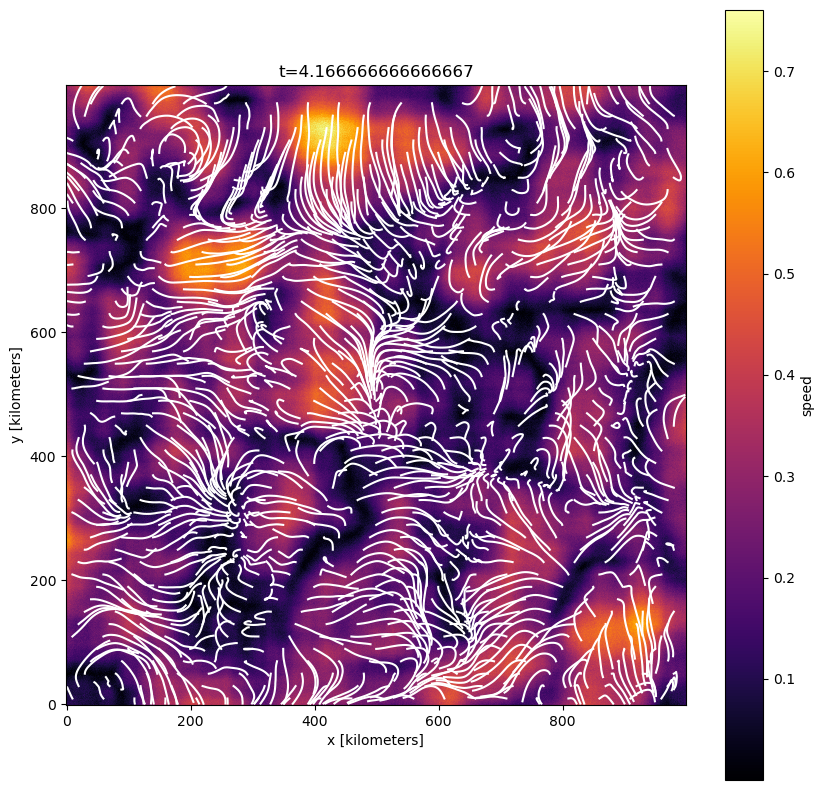

In [28]:
obs = 100

fig, ax = plt.subplots(1,1, figsize=(10,10))

_dso = ds.sel(obs=slice(None, obs))
t = float(_dso.t.max(skipna=True))

ds_in.sel(time=t, method="nearest").speed.plot(ax=ax, x="x", y="y", cmap="inferno")

for tr in _dso.trajectory[::10]:
    _ds = _dso.sel(trajectory=tr)
    ax.plot(_ds.x, _ds.y, color="w")

ax.set_aspect("equal")
ax.set_title(f"t={t}")

## massage and store trajectories

In [29]:
# trajectory reaching the end of the simulation
def select_add_velocities(ds):
    maxt = ds.time.max("obs")
    n0 = ds.trajectory.size
    ds = ds.where( ~np.isnan(maxt), drop=True)
    ns = ds.trajectory.size
    print(f"{ns/n0*100:.1f}% of trajectories survived")
    #
    dt = ds.t.differentiate("obs")*86400
    ds["u"] = ds.x.differentiate("obs")/dt*1e3 # x are in km
    ds["v"] = ds.y.differentiate("obs")/dt*1e3 # y are in km
    #
    t = ds.t
    #ds = ds.drop(["t", "time"])
    ds = ds.drop(["time"])
    ds["obs"] = ds.t.isel(trajectory=0)
    ds = ds.drop("t").rename(obs="time")

    return ds

dsf = select_add_velocities(ds)

# randomly select 20 trajectories
narrow_selection = np.random.choice(dsf.trajectory.values, 20)
dsn = dsf.sel(trajectory=narrow_selection)

47.2% of trajectories survived


Text(0.5, 1.0, 'drifters not reaching boundaries')

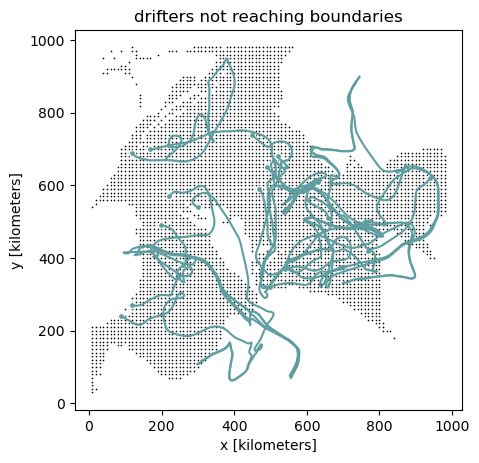

In [30]:
fig, ax = plt.subplots(1,1, figsize=(5,10))

dsf.isel(time=[0]).plot.scatter(ax=ax, x="x", y="y", c="k", s=5)
dsn.isel(time=[0]).plot.scatter(ax=ax, x="x", y="y", c="cadetblue", s=20)
#dsn.plot.scatter(ax=ax, x="x", y="y", c="cadetblue", s=20)
ax.plot(dsn.x.T, dsn.y.T, color="cadetblue")

ax.set_aspect("equal")
ax.set_title("drifters not reaching boundaries")

Text(0.5, 1.0, 'u for a trajectory selection')

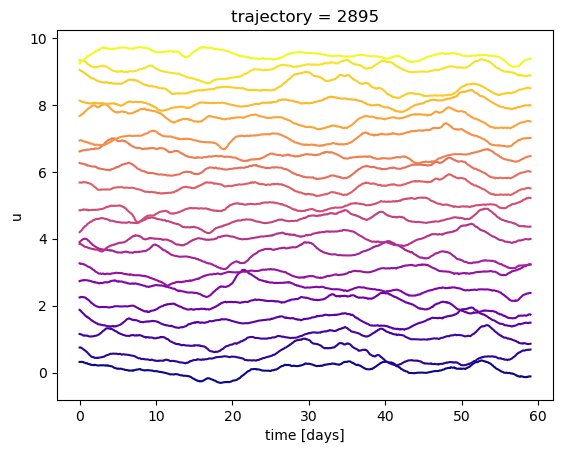

In [31]:
p = plt.get_cmap('plasma')
n = dsn.trajectory.size
for i, t in enumerate(dsn.trajectory):
    (dsn.sel(trajectory=t).u+i/2).plot(x="time", color=p(i/(n-1)))
ax.set_title("u for a trajectory selection")

In [32]:
# add attributes
dsn.attrs.update(
    l_x=ℓ_x, 
    l_y=ℓ_y, 
    l_t=ℓ_t,
    cov_x = "matern32",
    cov_y = "matern32",
    cov_t = "matern32",
)

dsn = dsn.drop("z")

In [35]:
dsn.to_netcdf("parcels_3D_selection.nc", mode="w")

In [46]:
ds_in_sel = (ds_in
    .sel(x=dsn.isel(time=0, drop=True).x, y=dsn.isel(time=0, drop=True).y, method="nearest")
    .drop("speed")
    .rename(U="u", V="v")
    .compute()
)

In [48]:
ds_in_sel = ds_in_sel.drop("speed").rename(U="u", V="v")

In [50]:
ds_in_sel.to_netcdf("uv_3D_selection.nc", mode="w")

### make movie

In [7]:
from tqdm import tqdm
import os

In [8]:
fig_dir = "/Users/aponte/tmp/figs"

def plot_snapshot(t, i, trail=2):

    fig, ax = plt.subplots(1,1, figsize=(10,10))

    _ds_in = ds_in.interp(time=t)
    #_ds_in = ds_in.sel(time=t, method="nearest")
    _ds_in.speed.plot(ax=ax, x="x", y="y", vmax=1, cmap="inferno")

    _ds = ds.isel(trajectory=slice(0,None,10))
    _ds = _ds.sel(obs=slice(t-trail, t))
    _ds.plot.scatter(ax=ax, x="x", y="y", c="0.5", s=0.1)

    ax.set_aspect("equal")
    ax.set_title(f"t={t:.2f}")
    
    fig_path = os.path.join(fig_dir, f"fig_{i:04}.png")
    fig.savefig(fig_path, dpi=150)
    # other relevant options: facecolor='w', bbox_inches = 'tight'
    plt.close(fig)

In [ ]:
for i, t in enumerate(tqdm(ds.obs.values[::4])):
    #print(float(t.values), i)
    plot_snapshot(t, i, trail=2)

 77%|██████████████████████████████████████████████████████████████████████████████████████████████                             | 267/349 [34:42<10:26,  7.64s/it]

---

## dev

In [ ]:
# for small size pb

zg_np = np.einsum("ij,kl,mn,jln->ikm", Lx, Ly, Lt, V.compute())

zg_da = da.einsum("ij,kl,mn,jln->ikm", Lx, Ly, Lt_dask, V).compute()

import opt_einsum as oe
zg_oe = oe.contract("ij,kl,mn,jln", Lx, Ly, Lt_dask, V).compute()


plt.imshow(zg_oe[...,0])
plt.colorbar()

plt.imshow(zg_oe[...,0] - zg_np[...,0])
plt.colorbar()

plt.imshow(zg_oe[...,0] - zg_da[...,0])
plt.colorbar()

In [ ]:
# inspect time increments of parcels output dataset
dt = (dsf.t.diff("obs").rename("dt")*24*60).round()
print(np.unique(dt)) # 30 or 60

traj_30 = list(ds.where(dt==30., drop=True).trajectory.values)
ds.sel(trajectory=traj_30[500]).t.diff("obs").plot() # last point may have 30min time increment

# conclusion: resample data before storing

In [ ]:
time = ds.time/pd.Timedelta("1H")
start = float(time.min(skipna=True))
end = float(time.max(skipna=True))
dt = float(time.diff("obs").median())
print(start, end, dt)

# potential common time line
t_target = np.arange(start, end+dt, dt)

def interpolate(ds):
    ds["obs"] = ds.time.squeeze()/pd.Timedelta("1H")
    ds = ds.where( ~np.isnan(ds.obs), drop=True)
    ds = ds.drop(["t", "time"])
    ds = ds.rename(obs="time")
    ds = ds.interp(time=t_target)
    #ds.interpolate
    return ds

# interpolate(ds.isel(trajectory=0))

# long if applied on full dataset
xr.concat([interpolate(dsf.isel(trajectory=i)) for i in range(dsf.trajectory.size)], "trajectory")